In this notebook, we're plotting which Counties have differences in demand as Origins vs as Destination (i.e. which Counties see more demand to leave or enter)

In [36]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
from IPython.display import display
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, shape

In [28]:
variation = pd.read_csv('intermediate-data/variation.csv')
demand_people = pd.read_csv('/home/primity/wdl/1-stage/intermediate-data/demand-people.csv')

variation.County_of_Origin=variation.County_of_Origin.str.upper()
variation.District_of_Origin=variation.District_of_Origin.str.upper()

demand_people.County_of_Origin=demand_people.County_of_Origin.str.upper()
demand_people.District_of_Origin=demand_people.District_of_Origin.str.upper()

In [29]:
demand_people.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Parish_of_Public_Transportation,Demand_weight,user_av,Avg_daily_travellers
0,R1 - AM Lisboa,LISBOA,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,Benfica,0.307323,7765.137315,2386.405295
1,R1 - AM Lisboa,LISBOA,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,São Domingos de Benfica,0.069997,7765.137315,543.536317


In [30]:
origin_travellers = demand_people.groupby(['County_of_Origin'])['Avg_daily_travellers'].sum().to_frame().reset_index().rename(columns= {'Avg_daily_travellers':'Avg_daily_travellers_origin'})
destination_travellers = demand_people.groupby(['County_of_Public_Transportation'])['Avg_daily_travellers'].sum().to_frame().reset_index().rename(columns= {'Avg_daily_travellers':'Avg_daily_travellers_destination'})

In [31]:
demand_people = pd.merge(origin_travellers, destination_travellers,
                    left_on=['County_of_Origin'], right_on=['County_of_Public_Transportation'])

In [33]:
demand_people['People_flow'] = demand_people['Avg_daily_travellers_origin'] - demand_people['Avg_daily_travellers_destination']

In [35]:
demand_people.sort_values('People_flow')

,County_of_Origin,Avg_daily_travellers_origin,County_of_Public_Transportation,Avg_daily_travellers_destination,People_flow
3,LISBOA,23273.781223,LISBOA,135651.726064,-112377.944841
10,PORTO,36819.247693,PORTO,111939.374889,-75120.127196
6,MATOSINHOS,13033.330507,MATOSINHOS,26216.831868,-13183.501361
11,SANTO TIRSO,36.789321,SANTO TIRSO,37.128074,-0.338753
9,PAREDES,392.183169,PAREDES,26.717248,365.465921
16,VILA DO CONDE,394.965038,VILA DO CONDE,4.352723,390.612315
14,TROFA,785.817497,TROFA,3.273275,782.544222
15,VALONGO,4419.651201,VALONGO,2049.480861,2370.170340
17,VILA NOVA DE GAIA,14092.995543,VILA NOVA DE GAIA,11315.221463,2777.774080
4,LOURES,7299.109217,LOURES,625.134535,6673.974681


In [37]:
counties_shapes = [[pol['properties']['NAME_2'], shape(pol['geometry'])] for pol in fiona.open("external-data/gadm36_PRT_shp/gadm36_PRT_2.shp")]
parishes_shapes = [[pol['properties']['NAME_3'], shape(pol['geometry'])] for pol in fiona.open("external-data/gadm36_PRT_shp/gadm36_PRT_3.shp")]

parishes_dict ={}
counties_dict = {}
for p in parishes_shapes:
    parishes_dict[p[0]]=p[1]
    
for p in counties_shapes:
    counties_dict[p[0]]=p[1]

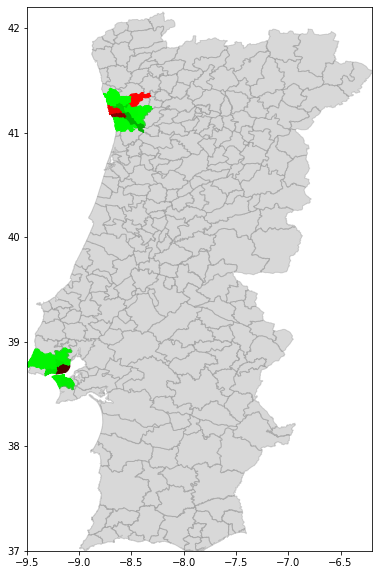

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Whole Country
ax.set_xlim(-9.5, -6.2)
ax.set_ylim(37, 42.2)

ax.set_aspect(1)
patches = []

for name, shape in counties_dict.items():    
    if shape.geom_type == 'MultiPolygon':
        for polygon in shape:
            if name.upper() in demand_people.County_of_Origin.tolist():
                c = demand_people.loc[demand_people['County_of_Origin'] == name.upper()].values[0][-1]
                if c >0:
                    g=1-c/160000
                    r=0
                else:
                    r=1+c/160000
                    g=0
                plt.fill(*polygon.exterior.xy, color=(r, g, 0)) 
            else:
                plt.fill(*polygon.exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
    else:
        if name.upper() in demand_people.County_of_Origin.tolist():
            c = demand_people.loc[demand_people['County_of_Origin'] == name.upper()].values[0][-1]
            if c >0:
                g=1-c/160000
                r=0
            else:
                r=1+c/160000
                g=0
            plt.fill(*counties_dict[name].exterior.xy, color=(r,g , 0))
        else:
            plt.fill(*counties_dict[name].exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
    
plt.show()